In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.metrics import mean_squared_error

# Use statsmodels ARIMA to fit and predict simulated data

In [ ]:
# -------------------------------------------------------------
# 1. Generate synthetic daily data (same recipe as before)
# -------------------------------------------------------------
np.random.seed(421)
ar = np.array([1, -0.5, 0.25])      # AR(2) ϕ(L) = 1 - 0.5L + 0.25L²
ma = np.array([1,  0.4, 0.3])       # MA(2) θ(L) = 1 + 0.4L + 0.3L²
arma_process = ArmaProcess(ar, ma)

n_obs = 365                         # one year
eps = arma_process.generate_sample(nsample=n_obs)

weekly = 10 * np.sin(2 * np.pi * np.arange(n_obs) / 7)  # deterministic seasonality
y = np.cumsum(eps + weekly) + 100                       # non‑stationary level

dates = pd.date_range("2024-01-01", periods=n_obs, freq="D")
series = pd.Series(y, index=dates, name="synthetic_cases")

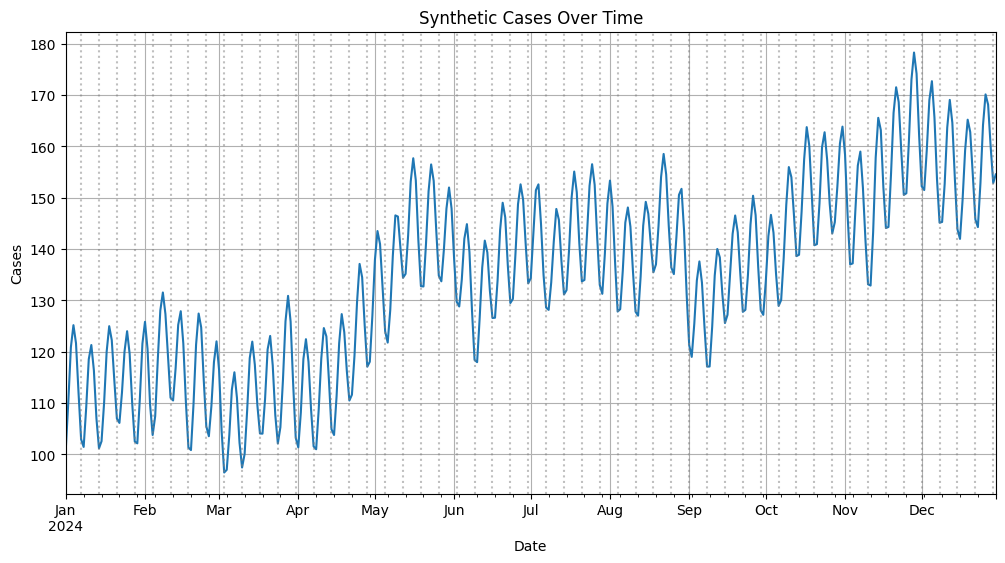

In [ ]:
series.plot(figsize=(12, 6))
plt.title('Synthetic Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.grid(True)

# Add vertical lines for weeks
weekly_dates = pd.date_range(series.index[0], series.index[-1], freq='W')
for week_date in weekly_dates:
    plt.axvline(week_date, color='grey', linestyle=':', alpha=0.5)

In [ ]:
# -------------------------------------------------------------
# 2. Split into train / validation
# -------------------------------------------------------------
n_valid = 60                       # hold‑out horizon (≈ 2 months)
train, valid = series[:-n_valid], series[-n_valid:]

# -------------------------------------------------------------
# 3. Fit ARIMA on the training portion
# -------------------------------------------------------------
model = ARIMA(train, order=(2, 1, 2), seasonal_order=(1, 0, 1, 7))
results = model.fit()

# -------------------------------------------------------------
# 4. Forecast over the validation period
# -------------------------------------------------------------
forecast_res = results.get_forecast(steps=n_valid)
pred_mean = forecast_res.predicted_mean
ci = forecast_res.conf_int()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Validation RMSE: 5.40


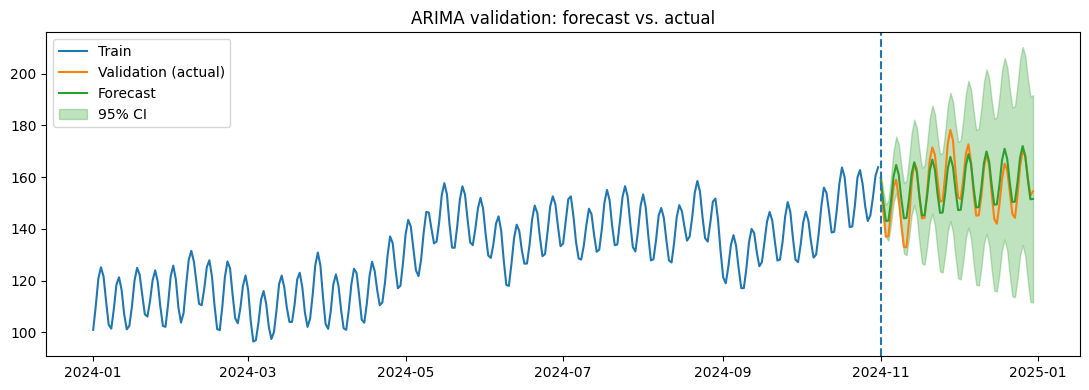

In [ ]:
# -------------------------------------------------------------
# 5. Compute a simple accuracy metric (RMSE)
# -------------------------------------------------------------
rmse = np.sqrt(mean_squared_error(valid, pred_mean))
print(f"Validation RMSE: {rmse:0.2f}")

# -------------------------------------------------------------
# 6. Plot: train, validation, forecast, and 95 % CI
# -------------------------------------------------------------
plt.figure(figsize=(11, 4))
plt.plot(train, label="Train")
plt.plot(valid, label="Validation (actual)")
plt.plot(pred_mean, label="Forecast", color='C2')
plt.fill_between(pred_mean.index,
                 ci.iloc[:, 0],
                 ci.iloc[:, 1],
                 alpha=0.3, label="95% CI", color='C2')
plt.axvline(valid.index[0], linestyle="--")  # marks forecast origin
plt.title("ARIMA validation: forecast vs. actual")
plt.legend()
plt.tight_layout()

# Which parameters seem best, based on the data?

In [ ]:
import itertools
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

p = d = q = range(0, 3)            # 0,1,2   (adjust as needed)
pdq     = list(itertools.product(p, d, q))
season  = [(x[0], x[1], x[2], 7) for x in pdq if np.all(np.array(x) < 2)]  # weekly seasonality

best_aic   = np.inf
best_order = None
best_seasonal = None
best_model = None

for order in pdq:
    for s_order in season:
        try:
            print(f"Testing ARIMA{order}x{s_order}...")
            mod = ARIMA(y, order=order, seasonal_order=s_order)
            res = mod.fit()
            print(f"  AIC: {res.aic:.2f}")
            if res.aic < best_aic:
                best_aic, best_order, best_seasonal, best_model = \
                    res.aic, order, s_order, res
                print(f"  New best model! AIC: {best_aic:.2f}")
        except Exception:
            print(f"  Failed to fit ARIMA{order}x{s_order}.")
            continue                                   # skip non-invertible combos
        print()

Testing ARIMA(0, 0, 0)x(0, 0, 0, 7)...
  AIC: 3153.05
  New best model! AIC: 3153.05

Testing ARIMA(0, 0, 0)x(0, 0, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


  AIC: 2780.90
  New best model! AIC: 2780.90

Testing ARIMA(0, 0, 0)x(0, 1, 0, 7)...
  AIC: 2287.34
  New best model! AIC: 2287.34

Testing ARIMA(0, 0, 0)x(0, 1, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


  AIC: 2287.90

Testing ARIMA(0, 0, 0)x(1, 0, 0, 7)...
  AIC: 2347.50

Testing ARIMA(0, 0, 0)x(1, 0, 1, 7)...
  AIC: 2346.36

Testing ARIMA(0, 0, 0)x(1, 1, 0, 7)...
  AIC: 2288.48

Testing ARIMA(0, 0, 0)x(1, 1, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


  AIC: 2278.88
  New best model! AIC: 2278.88

Testing ARIMA(0, 0, 1)x(0, 0, 0, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  AIC: 2682.72

Testing ARIMA(0, 0, 1)x(0, 0, 1, 7)...
  AIC: 2359.69

Testing ARIMA(0, 0, 1)x(0, 1, 0, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  AIC: 1874.96
  New best model! AIC: 1874.96

Testing ARIMA(0, 0, 1)x(0, 1, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


  AIC: 1876.48

Testing ARIMA(0, 0, 1)x(1, 0, 0, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  AIC: 1926.60

Testing ARIMA(0, 0, 1)x(1, 0, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


  AIC: 1928.59

Testing ARIMA(0, 0, 1)x(1, 1, 0, 7)...
  AIC: 1876.66

Testing ARIMA(0, 0, 1)x(1, 1, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


  AIC: 1871.13
  New best model! AIC: 1871.13

Testing ARIMA(0, 0, 2)x(0, 0, 0, 7)...
  AIC: 2281.06

Testing ARIMA(0, 0, 2)x(0, 0, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


  AIC: 1936.45

Testing ARIMA(0, 0, 2)x(0, 1, 0, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  AIC: 1500.30
  New best model! AIC: 1500.30

Testing ARIMA(0, 0, 2)x(0, 1, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


  AIC: 1502.04

Testing ARIMA(0, 0, 2)x(1, 0, 0, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  AIC: 1533.31

Testing ARIMA(0, 0, 2)x(1, 0, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  AIC: 1534.85

Testing ARIMA(0, 0, 2)x(1, 1, 0, 7)...
  AIC: 1502.12

Testing ARIMA(0, 0, 2)x(1, 1, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


  AIC: 1500.35

Testing ARIMA(0, 1, 0)x(0, 0, 0, 7)...
  AIC: 2468.49

Testing ARIMA(0, 1, 0)x(0, 0, 1, 7)...
  AIC: 2130.30

Testing ARIMA(0, 1, 0)x(0, 1, 0, 7)...
  AIC: 1499.51
  New best model! AIC: 1499.51

Testing ARIMA(0, 1, 0)x(0, 1, 1, 7)...
  AIC: 1303.93
  New best model! AIC: 1303.93

Testing ARIMA(0, 1, 0)x(1, 0, 0, 7)...
  AIC: 1542.59

Testing ARIMA(0, 1, 0)x(1, 0, 1, 7)...
  AIC: 1353.12

Testing ARIMA(0, 1, 0)x(1, 1, 0, 7)...
  AIC: 1425.13

Testing ARIMA(0, 1, 0)x(1, 1, 1, 7)...
  AIC: 1304.34

Testing ARIMA(0, 1, 1)x(0, 0, 0, 7)...
  AIC: 2102.43

Testing ARIMA(0, 1, 1)x(0, 0, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  AIC: 1851.69

Testing ARIMA(0, 1, 1)x(0, 1, 0, 7)...
  AIC: 1317.72

Testing ARIMA(0, 1, 1)x(0, 1, 1, 7)...
  AIC: 1110.13
  New best model! AIC: 1110.13

Testing ARIMA(0, 1, 1)x(1, 0, 0, 7)...
  AIC: 1353.98

Testing ARIMA(0, 1, 1)x(1, 0, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  AIC: 1153.80

Testing ARIMA(0, 1, 1)x(1, 1, 0, 7)...
  AIC: 1234.32

Testing ARIMA(0, 1, 1)x(1, 1, 1, 7)...
  AIC: 1111.81

Testing ARIMA(0, 1, 2)x(0, 0, 0, 7)...
  AIC: 1860.67

Testing ARIMA(0, 1, 2)x(0, 0, 1, 7)...
  AIC: 1617.32

Testing ARIMA(0, 1, 2)x(0, 1, 0, 7)...
  AIC: 1238.97

Testing ARIMA(0, 1, 2)x(0, 1, 1, 7)...
  AIC: 1038.17
  New best model! AIC: 1038.17

Testing ARIMA(0, 1, 2)x(1, 0, 0, 7)...
  AIC: 1269.30

Testing ARIMA(0, 1, 2)x(1, 0, 1, 7)...
  AIC: 1078.70

Testing ARIMA(0, 1, 2)x(1, 1, 0, 7)...
  AIC: 1162.82

Testing ARIMA(0, 1, 2)x(1, 1, 1, 7)...
  AIC: 1039.54

Testing ARIMA(0, 2, 0)x(0, 0, 0, 7)...
  AIC: 2356.74

Testing ARIMA(0, 2, 0)x(0, 0, 1, 7)...
  AIC: 2028.57

Testing ARIMA(0, 2, 0)x(0, 1, 0, 7)...
  AIC: 1370.84

Testing ARIMA(0, 2, 0)x(0, 1, 1, 7)...
  AIC: 1163.29

Testing ARIMA(0, 2, 0)x(1, 0, 0, 7)...
  AIC: 1412.62

Testing ARIMA(0, 2, 0)x(1, 0, 1, 7)...
  AIC: 1210.59

Testing ARIMA(0, 2, 0)x(1, 1, 0, 7)...
  AIC: 1271.04

Testing ARIMA(0, 2

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


  AIC: 2128.42

Testing ARIMA(1, 0, 0)x(0, 1, 0, 7)...
  AIC: 1498.25

Testing ARIMA(1, 0, 0)x(0, 1, 1, 7)...
  AIC: 1308.82

Testing ARIMA(1, 0, 0)x(1, 0, 0, 7)...
  AIC: 1545.30

Testing ARIMA(1, 0, 0)x(1, 0, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


  AIC: 1367.92

Testing ARIMA(1, 0, 0)x(1, 1, 0, 7)...
  AIC: 1427.01

Testing ARIMA(1, 0, 0)x(1, 1, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


  AIC: 1309.26

Testing ARIMA(1, 0, 1)x(0, 0, 0, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  AIC: 2098.03

Testing ARIMA(1, 0, 1)x(0, 0, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


  AIC: 1845.22

Testing ARIMA(1, 0, 1)x(0, 1, 0, 7)...
  AIC: 1311.76

Testing ARIMA(1, 0, 1)x(0, 1, 1, 7)...
  AIC: 1115.08

Testing ARIMA(1, 0, 1)x(1, 0, 0, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  AIC: 1351.42

Testing ARIMA(1, 0, 1)x(1, 0, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


  AIC: 1167.73

Testing ARIMA(1, 0, 1)x(1, 1, 0, 7)...
  AIC: 1233.37

Testing ARIMA(1, 0, 1)x(1, 1, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


  AIC: 1117.32

Testing ARIMA(1, 0, 2)x(0, 0, 0, 7)...
  AIC: 1849.44

Testing ARIMA(1, 0, 2)x(0, 0, 1, 7)...
  AIC: 1600.14

Testing ARIMA(1, 0, 2)x(0, 1, 0, 7)...
  AIC: 1223.14

Testing ARIMA(1, 0, 2)x(0, 1, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


  AIC: 1043.42

Testing ARIMA(1, 0, 2)x(1, 0, 0, 7)...
  AIC: 1256.21

Testing ARIMA(1, 0, 2)x(1, 0, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


  AIC: 1090.60

Testing ARIMA(1, 0, 2)x(1, 1, 0, 7)...
  AIC: 1155.76

Testing ARIMA(1, 0, 2)x(1, 1, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


  AIC: 1044.69

Testing ARIMA(1, 1, 0)x(0, 0, 0, 7)...
  AIC: 2290.17

Testing ARIMA(1, 1, 0)x(0, 0, 1, 7)...
  AIC: 1959.27

Testing ARIMA(1, 1, 0)x(0, 1, 0, 7)...
  AIC: 1308.53

Testing ARIMA(1, 1, 0)x(0, 1, 1, 7)...
  AIC: 1102.93

Testing ARIMA(1, 1, 0)x(1, 0, 0, 7)...
  AIC: 1348.87

Testing ARIMA(1, 1, 0)x(1, 0, 1, 7)...
  AIC: 1148.87

Testing ARIMA(1, 1, 0)x(1, 1, 0, 7)...
  AIC: 1214.47

Testing ARIMA(1, 1, 0)x(1, 1, 1, 7)...
  AIC: 1104.77

Testing ARIMA(1, 1, 1)x(0, 0, 0, 7)...
  AIC: 1979.84

Testing ARIMA(1, 1, 1)x(0, 0, 1, 7)...
  AIC: 1760.93

Testing ARIMA(1, 1, 1)x(0, 1, 0, 7)...
  AIC: 1269.18

Testing ARIMA(1, 1, 1)x(0, 1, 1, 7)...
  AIC: 1061.62

Testing ARIMA(1, 1, 1)x(1, 0, 0, 7)...
  AIC: 1303.73

Testing ARIMA(1, 1, 1)x(1, 0, 1, 7)...
  AIC: 1104.04

Testing ARIMA(1, 1, 1)x(1, 1, 0, 7)...
  AIC: 1180.39

Testing ARIMA(1, 1, 1)x(1, 1, 1, 7)...
  AIC: 1063.38

Testing ARIMA(1, 1, 2)x(0, 0, 0, 7)...
  AIC: 1782.83

Testing ARIMA(1, 1, 2)x(0, 0, 1, 7)...
  AIC: 160

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  AIC: 1717.74

Testing ARIMA(1, 2, 2)x(0, 1, 0, 7)...
  AIC: 1272.58

Testing ARIMA(1, 2, 2)x(0, 1, 1, 7)...
  AIC: 1071.30

Testing ARIMA(1, 2, 2)x(1, 0, 0, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  AIC: 1301.62

Testing ARIMA(1, 2, 2)x(1, 0, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  AIC: 1101.37

Testing ARIMA(1, 2, 2)x(1, 1, 0, 7)...
  AIC: 1184.70

Testing ARIMA(1, 2, 2)x(1, 1, 1, 7)...
  AIC: 1072.82

Testing ARIMA(2, 0, 0)x(0, 0, 0, 7)...
  AIC: 2234.72

Testing ARIMA(2, 0, 0)x(0, 0, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


  AIC: 1900.11

Testing ARIMA(2, 0, 0)x(0, 1, 0, 7)...
  AIC: 1267.75

Testing ARIMA(2, 0, 0)x(0, 1, 1, 7)...
  AIC: 1104.59

Testing ARIMA(2, 0, 0)x(1, 0, 0, 7)...
  AIC: 1309.01

Testing ARIMA(2, 0, 0)x(1, 0, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


  AIC: 1154.75

Testing ARIMA(2, 0, 0)x(1, 1, 0, 7)...
  AIC: 1190.90

Testing ARIMA(2, 0, 0)x(1, 1, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


  AIC: 1106.59

Testing ARIMA(2, 0, 1)x(0, 0, 0, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  AIC: 1923.03

Testing ARIMA(2, 0, 1)x(0, 0, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


  AIC: 1708.49

Testing ARIMA(2, 0, 1)x(0, 1, 0, 7)...
  AIC: 1241.36

Testing ARIMA(2, 0, 1)x(0, 1, 1, 7)...
  AIC: 1065.75

Testing ARIMA(2, 0, 1)x(1, 0, 0, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  AIC: 1277.58

Testing ARIMA(2, 0, 1)x(1, 0, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  AIC: 1114.58

Testing ARIMA(2, 0, 1)x(1, 1, 0, 7)...
  AIC: 1165.29

Testing ARIMA(2, 0, 1)x(1, 1, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


  AIC: 1068.56

Testing ARIMA(2, 0, 2)x(0, 0, 0, 7)...
  AIC: 1716.18

Testing ARIMA(2, 0, 2)x(0, 0, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


  AIC: 1552.95

Testing ARIMA(2, 0, 2)x(0, 1, 0, 7)...
  AIC: 1221.01

Testing ARIMA(2, 0, 2)x(0, 1, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


  AIC: 1044.91

Testing ARIMA(2, 0, 2)x(1, 0, 0, 7)...
  AIC: 1252.35

Testing ARIMA(2, 0, 2)x(1, 0, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


  AIC: 1091.36

Testing ARIMA(2, 0, 2)x(1, 1, 0, 7)...
  AIC: 1153.55

Testing ARIMA(2, 0, 2)x(1, 1, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


  AIC: 1046.16

Testing ARIMA(2, 1, 0)x(0, 0, 0, 7)...
  AIC: 1174.82

Testing ARIMA(2, 1, 0)x(0, 0, 1, 7)...
  AIC: 1176.82

Testing ARIMA(2, 1, 0)x(0, 1, 0, 7)...
  AIC: 1261.41

Testing ARIMA(2, 1, 0)x(0, 1, 1, 7)...
  AIC: 1048.31

Testing ARIMA(2, 1, 0)x(1, 0, 0, 7)...
  AIC: 1176.82

Testing ARIMA(2, 1, 0)x(1, 0, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  AIC: 1087.14

Testing ARIMA(2, 1, 0)x(1, 1, 0, 7)...
  AIC: 1175.07

Testing ARIMA(2, 1, 0)x(1, 1, 1, 7)...
  AIC: 1050.25

Testing ARIMA(2, 1, 1)x(0, 0, 0, 7)...
  AIC: 1175.26

Testing ARIMA(2, 1, 1)x(0, 0, 1, 7)...
  AIC: 1177.26

Testing ARIMA(2, 1, 1)x(0, 1, 0, 7)...
  AIC: 1260.30

Testing ARIMA(2, 1, 1)x(0, 1, 1, 7)...
  AIC: 1049.76

Testing ARIMA(2, 1, 1)x(1, 0, 0, 7)...
  AIC: 1300.60

Testing ARIMA(2, 1, 1)x(1, 0, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  AIC: 1089.01

Testing ARIMA(2, 1, 1)x(1, 1, 0, 7)...
  AIC: 1175.29

Testing ARIMA(2, 1, 1)x(1, 1, 1, 7)...
  AIC: 1051.64

Testing ARIMA(2, 1, 2)x(0, 0, 0, 7)...
  AIC: 1158.16

Testing ARIMA(2, 1, 2)x(0, 0, 1, 7)...
  AIC: 1159.25

Testing ARIMA(2, 1, 2)x(0, 1, 0, 7)...
  AIC: 1225.33

Testing ARIMA(2, 1, 2)x(0, 1, 1, 7)...
  AIC: 1065.75

Testing ARIMA(2, 1, 2)x(1, 0, 0, 7)...
  AIC: 1260.12

Testing ARIMA(2, 1, 2)x(1, 0, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  AIC: 1087.77

Testing ARIMA(2, 1, 2)x(1, 1, 0, 7)...
  AIC: 1184.39

Testing ARIMA(2, 1, 2)x(1, 1, 1, 7)...
  AIC: 1067.21

Testing ARIMA(2, 2, 0)x(0, 0, 0, 7)...
  AIC: 1437.38

Testing ARIMA(2, 2, 0)x(0, 0, 1, 7)...
  AIC: 1437.74

Testing ARIMA(2, 2, 0)x(0, 1, 0, 7)...
  AIC: 1316.80

Testing ARIMA(2, 2, 0)x(0, 1, 1, 7)...
  AIC: 1122.52

Testing ARIMA(2, 2, 0)x(1, 0, 0, 7)...
  AIC: 1354.42

Testing ARIMA(2, 2, 0)x(1, 0, 1, 7)...
  AIC: 1166.89

Testing ARIMA(2, 2, 0)x(1, 1, 0, 7)...
  AIC: 1232.04

Testing ARIMA(2, 2, 0)x(1, 1, 1, 7)...
  AIC: 1123.52

Testing ARIMA(2, 2, 1)x(0, 0, 0, 7)...
  AIC: 1176.95

Testing ARIMA(2, 2, 1)x(0, 0, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  AIC: 1178.95

Testing ARIMA(2, 2, 1)x(0, 1, 0, 7)...
  AIC: 1265.26

Testing ARIMA(2, 2, 1)x(0, 1, 1, 7)...
  AIC: 1058.19

Testing ARIMA(2, 2, 1)x(1, 0, 0, 7)...
  AIC: 1178.95

Testing ARIMA(2, 2, 1)x(1, 0, 1, 7)...
  AIC: 1181.50

Testing ARIMA(2, 2, 1)x(1, 1, 0, 7)...
  AIC: 1179.74

Testing ARIMA(2, 2, 1)x(1, 1, 1, 7)...
  AIC: 1060.09

Testing ARIMA(2, 2, 2)x(0, 0, 0, 7)...
  AIC: 1139.87

Testing ARIMA(2, 2, 2)x(0, 0, 1, 7)...
  AIC: 1124.02

Testing ARIMA(2, 2, 2)x(0, 1, 0, 7)...
  AIC: 1263.01

Testing ARIMA(2, 2, 2)x(0, 1, 1, 7)...
  AIC: 1059.60

Testing ARIMA(2, 2, 2)x(1, 0, 0, 7)...
  AIC: 1285.89

Testing ARIMA(2, 2, 2)x(1, 0, 1, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  AIC: 1143.58

Testing ARIMA(2, 2, 2)x(1, 1, 0, 7)...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  AIC: 1179.88

Testing ARIMA(2, 2, 2)x(1, 1, 1, 7)...
  AIC: 1061.42



In [ ]:
print(f"\nBest model: ARIMA{best_order}x{best_seasonal}  AIC={best_aic:.2f}")
print(best_model.summary())


Best model: ARIMA(0, 1, 2)x(0, 1, 1, 7)  AIC=1038.17
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  365
Model:             ARIMA(0, 1, 2)x(0, 1, [1], 7)   Log Likelihood                -515.085
Date:                           Fri, 04 Jul 2025   AIC                           1038.170
Time:                                   18:46:13   BIC                           1053.681
Sample:                                        0   HQIC                          1044.339
                                           - 365                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9204      0.045     20.424      0.000       0.832  

# Might it be interesting to see the coefficients in the model after it is fit?

In [ ]:
# Fit ARIMA(2,1,2) without seasonal component
model = ARIMA(y, order=(2, 1, 2))
results = model.fit()

# Extract and print coefficients
coef_table = pd.DataFrame({
    "coef": results.params,
    "std_err": results.bse,
    "p_value": results.pvalues
},    index=results.param_names               # ← human-readable names
)
coef_table.index.name = "parameter"         # optional aesthetic touch
coef_table

,coef,std_err,p_value
parameter,,,
ar.L1,1.236965,0.009987,0.000000e+00
ar.L2,-0.983474,0.009715,0.000000e+00
ma.L1,-0.124546,0.056765,2.822940e-02
ma.L2,0.194130,0.054906,4.067055e-04
sigma2,1.346270,0.106296,9.209164e-37


### Reading the coefficient names

For an **ARIMA(p = 2, d = 1, q = 2)** the model written on the *differenced* series
$w_t = y_t - y_{t-1}$ is

$$
w_t
  \;=\;
  \underbrace{\phi_1\,w_{t-1} + \phi_2\,w_{t-2}}_{\text{AR part}}
  \;+\;
  \underbrace{e_t + \theta_1\,e_{t-1} + \theta_2\,e_{t-2}}_{\text{MA part}},
  \qquad e_t\sim\mathcal{N}(0,\sigma^2).
$$

`statsmodels` prints those coefficients with the tags:

| Output label | Symbol in equation | Meaning                                                                                                                                                                  |
| ------------ | ------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **ar.L1**    | $\phi_1$           | Weight on **L**ag-1 of the differenced series $w_{t-1}$.  Positive and close to 1 means yesterday’s change still pushes today in the same direction.                     |
| **ar.L2**    | $\phi_2$           | Weight on **L**ag-2 of $w_t$.  A negative value, like –0.98 in your fit, creates an “echo” two days later that partially reverses the previous move (think oscillation). |
| **ma.L1**    | $\theta_1$         | How much of yesterday’s shock $e_{t-1}$ is *cancelled or reinforced* today.  Negative $\theta_1$ dampens a positive shock one day later.                                 |
| **ma.L2**    | $\theta_2$         | Same idea but for the shock two days ago.                                                                                                                                |
| **sigma2**   | $\sigma^{2}$       | Estimated variance of the white-noise innovations $e_t$.                                                                                                                 |

### There is no `drift` parameter here

* In `statsmodels`, when you set **`d` > 0** *and leave the default `trend="n"`*, the package assumes **no deterministic trend** in the differenced series, so no constant (and therefore no “drift” after integrating back to $y_t$) is estimated.
* If you *do* want a deterministic drift, specify it explicitly:

```python
model = ARIMA(y, order=(2, 1, 2), trend="t")   # ‘t’ = linear drift after differencing
```

That would add a `drift` (or `const` if `d=0`) row to the table.


### These values are not close to the values we used when generating the data!


In [ ]:
# Fit ARIMA(2,1,2) with seasonal component
model = ARIMA(y, order=(2, 1, 2), seasonal_order=(1, 0, 1, 7))
results = model.fit()

# Extract and print coefficients
coef_table = pd.DataFrame({
    "coef": results.params,
    "std_err": results.bse,
    "p_value": results.pvalues
},    index=results.param_names               # ← human-readable names
)
coef_table.index.name = "parameter"         # optional aesthetic touch
coef_table

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,coef,std_err,p_value
parameter,,,
ar.L1,0.371782,0.169863,2.861726e-02
ar.L2,-0.196627,0.108592,7.018887e-02
ma.L1,0.628329,0.165265,1.435676e-04
ma.L2,0.376782,0.089906,2.779124e-05
ar.S.L7,0.999241,0.000714,0.000000e+00
ma.S.L7,-0.918399,0.034843,4.143917e-153
sigma2,1.045563,0.088110,1.765853e-32
